## Import libraries

In [2]:
pip install segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 55.1 MB/s eta 0:00:00:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=bd6d1dce466956c578c04269fca654e197bbecb47a83f556a8a6e7a718f37bac
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=9efc8881e0783c96d2d4f74bced13239546c69a9007c0f77aa5df10f54c8b520
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-p

In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2

import math
from torch.utils.data import DataLoader, distributed
import torch

from typing import Dict, Union, Tuple, List
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

from transformers import SegformerForSemanticSegmentation, SegformerConfig
from torch.cuda import amp

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [4]:
import segmentation_models_pytorch as smp

## Load date from NP

In [4]:
data = np.load("/kaggle/input/ensembled_dataset.npz")
X = data['dataset']
y = data['masks']

In [ ]:
X = np.squeeze(X)
print('X.shape:', X.shape)
print('y.shape:', y.shape)

### encode_label_from_label_map

- **Input**:  
  - `label` (np.ndarray): A color image (H, W, 3) representing segmentation labels.  
  - `label_map` (Dict): A dictionary mapping class names to their corresponding RGB colors.  
- **Output**:  
  - `np.ndarray`: A one-hot encoded mask of shape (H, W, n_classes).  
- **Usage**: Converts a color-coded label into a one-hot encoded mask for semantic segmentation.  


### decode_mask_from_color_map

- **Input**:  
  - `mask` (np.ndarray or torch.Tensor): A one-hot encoded mask of shape (H, W, n_classes).  
  - `color_map` (Dict): A dictionary mapping class names to their corresponding RGB colors.  
- **Output**:  
  - `np.ndarray`: A decoded color image of shape (H, W, 3).  
- **Usage**: Converts a one-hot encoded mask back into a color-coded label for visualization.  

In [6]:
def encode_label_from_label_map(label: np.ndarray, label_map: Dict) -> np.ndarray:
    def multy_along_three_axis(a1, a2, a3):
        return a1 * a2 * a3

    n_classes = len(label_map.keys())
    h, w = label.shape[:2]
    mask = np.zeros((h, w, n_classes), dtype=np.float32)
    for idx, cls in enumerate(label_map.keys()):
        color = label_map[cls]
        ij = label == color
        if ij.ndim == 3:
            ij = multy_along_three_axis(*ij.transpose(2, 0, 1))
        mask[ij, idx] = 1

    return mask

def decode_mask_from_color_map(mask, color_map: Dict):
    if isinstance(torch.tensor, type(mask)):
        mask = mask.permute(1, 2, 0).numpy()

    h, w = mask.shape[:2]
    label = np.zeros((h, w, 3), dtype=np.uint8)
    for idx, cls in enumerate(color_map.keys()):
        color = color_map[cls]
        label[mask[..., idx] == 1] = color

    return label

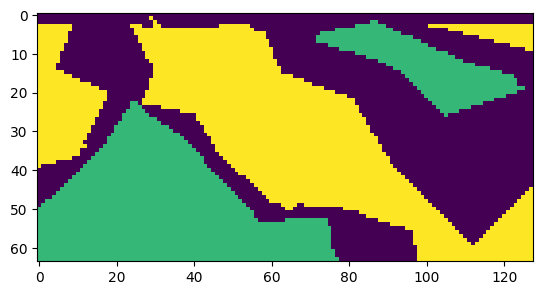

In [7]:
plt.imshow(y[6])

## Augmentation

In [8]:
from typing import List

import cv2
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

def geom_augs() -> A.Compose:
    return A.Compose(
        [
            A.OneOf(
                [
                    A.ShiftScaleRotate(
                        shift_limit=0.0825, scale_limit=0.2, rotate_limit=10, value=0, border_mode=cv2.BORDER_CONSTANT
                    ),
                    A.Rotate(limit=(-10, 10)),
                ]
            ),
            A.OneOf(
                [
                    A.VerticalFlip(),
                    A.HorizontalFlip(),
                ]
            ),
        ]
    )

def values_augs() -> A.Compose:
    return A.Compose(
        [
            A.OneOf(
                [
                    A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1)),
                    A.ISONoise(),
                    A.Blur(),
                    A.CLAHE(),
                    A.Sharpen(),
                    A.PixelDropout(),
                    A.AdvancedBlur(),
                    A.Defocus(),
                ],
            ),
            A.OneOf(
                [
                    A.HueSaturationValue(),
                    A.OpticalDistortion(),
                ]
            ),
        ]
    )

def augs_pipeline() -> A.Compose:
    return A.Compose(
        [
            values_augs(),
            geom_augs(),
        ]
    )


def pre_processing_pipeline(image_size: List[int]) -> A.Compose:
    return A.Compose([A.RandomResizedCrop(scale=(0.6, 1), height=image_size[0], width=image_size[1], p=0.5)])


def post_processing_pipeline(image_size: List[int]) -> A.Compose:
    return A.Compose(
        [
            A.PadIfNeeded(min_height=image_size[0], min_width=image_size[1], value=0, border_mode=cv2.BORDER_CONSTANT),
            A.RandomCrop(height=image_size[0], width=image_size[1], always_apply=True),
        ]
    )


def train_transforms(*args, **kwargs) -> A.Compose:
    return A.Compose(
        [
            augs_pipeline(),
        ]
    )


def valid_transforms(*args, **kwargs) -> A.Compose:
    return A.Compose(
        [
            augs_pipeline(),
        ]
    )

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# MarsSurface Class

`__init__(self, mode: str, X, y, label_map_dict, color_map_dict, train_transforms, valid_transforms)`
Initializes the dataset class for the Mars surface segmentation task.

- **Input**:
  - `mode` (str): Specifies the mode of the dataset, one of ["train", "valid", "test", "debug"].
  - `X`: The input images (array or list-like structure).
  - `y`: The corresponding labels for the images.
  - `label_map_dict` (dict): A dictionary mapping class names to their labels.
  - `color_map_dict` (dict): A dictionary mapping class names to their RGB color representation.
  - `train_transforms` (callable): Transformations to be applied during training.
  - `valid_transforms` (callable): Transformations to be applied during validation/testing.

- **Output**: None


`_read_data(self, item: int)`
Reads and preprocesses a single data point from the dataset.

- **Input**:
  - `item` (int): Index of the data point to read.

- **Output**:
  - `image` (np.ndarray): The preprocessed image.
  - `label` (np.ndarray): The corresponding label encoded using `label_map_dict`.


`_decode_label(self, label_map)`
Encodes the label map into a one-hot encoded mask.

- **Input**:
  - `label_map` (np.ndarray): The label map for the given image.

- **Output**:
  - `mask` (np.ndarray): One-hot encoded mask of shape (H, W, n_classes).


`__len__(self)`
Returns the total number of samples in the dataset.

- **Input**: None

- **Output**:
  - (int): Number of samples.


`__getitem__(self, item: int)`
Fetches a data point, applies transformations, and prepares it for training or evaluation.

- **Input**:
  - `item` (int): Index of the data point.

- **Output**:
  - `image` (torch.Tensor): The transformed image tensor of shape (3, H, W).
  - `mask` (torch.Tensor): The one-hot encoded mask tensor of shape (n_classes, H, W).
  - `zero_mask` (torch.Tensor): A mask highlighting unannotated areas of shape (n_classes, H, W).
  - `_label` (torch.Tensor): The decoded RGB mask tensor of shape (3, H, W).

In [9]:
from torch.utils.data import Dataset

class MarsSurface(Dataset):
    
    def __init__(self, mode: str, X, y, label_map_dict, color_map_dict, train_transforms = train_transforms, valid_transforms = valid_transforms ):
        assert mode in ["train", "valid","test", "debug"], "Invalid value for self.mode, type 'train' or 'test'"
        self.label_map_dict = label_map_dict
        self.color_map_dict = color_map_dict
        self.mode = mode
        self.transforms = train_transforms if self.mode in ["train", "debug"] else valid_transforms

        self.img_size = [64, 128]
        self.X = X
        self.y = y

    def _read_data(self, item: int):
        image = self.X[item]
        if image.max() > 1:
            image = (image  / 255).astype("float32")
        label = self._decode_label(self.y[item])

        return image, label

    def _decode_label(self, label_map):
        return encode_label_from_label_map(label_map, self.label_map_dict)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, item: int):
        image, mask = self._read_data(item)
        _label = decode_mask_from_color_map(mask, self.color_map_dict)

        mask = torch.from_numpy(mask).permute(2, 0, 1).float()
        image = torch.from_numpy(image).float()
        _label = torch.from_numpy(_label).permute(2, 0, 1).float()

        # hide values on mask which aren't annotated
        zero_mask = 1 - mask[0,...]
        zero_mask = torch.stack([zero_mask] * 5)

        return image, mask, zero_mask, _label

# Labels for decoding
label_map_dict = {
  'Terrain1': [0],
  'Terrain2': [1],
  'Terrain3': [2],
  'Terrain4': [3],
  'Terrain5': [4],

}

# Colors for plotting and encoding
color_map_dict = {
  'Terrain1': [0, 0, 0],
  'Terrain2': [254, 0, 254],
  'Terrain3': [0, 253, 0],
  'Terrain4': [0, 0, 252],
  'Terrain5': [250, 250, 250],
}

In [10]:
def create_datasets(X, y, label_map_dict, color_map_dict):
    
    X_train, X_val, y_train, y_val = train_test_split(
        X,
        y,
        test_size = 50,
        random_state = 7
    )

    train_dataset = MarsSurface(
        mode = "train",
        X = X_train,
        y = y_train,
        label_map_dict = label_map_dict,
        color_map_dict = color_map_dict
    )
    
    valid_dataset = MarsSurface(
        mode = "valid",
        X = X_val,
        y = y_val,
        label_map_dict = label_map_dict,
        color_map_dict = color_map_dict
    )

    return train_dataset, valid_dataset

## Losses

In [11]:
def dice_channel_torch(probability, truth, threshold):
    batch_size = truth.shape[0]
    channel_num = truth.shape[1]
    mean_dice_channel = 0.0
    dice_channels = [0.0] * channel_num
    with torch.no_grad():
        for i in range(batch_size):
            for j in range(channel_num):
                channel_dice = dice_single_channel(probability[i, j, :, :], truth[i, j, :, :], threshold)
                dice_channels[j] += channel_dice / batch_size
                mean_dice_channel += channel_dice / (batch_size * channel_num)
    return mean_dice_channel, dice_channels

def dice_single_channel(probability, truth, threshold, eps=1e-9):
    t = truth.flatten() > 0.5
    p = probability.flatten() > threshold
    dice = (2.0 * (p * t).sum() + eps) / (p.sum() + t.sum() + eps)
    return dice

def focal_binary_cross_entropy(logits, targets, gamma=2):
    num_label = 5
    l = logits.reshape(-1)
    t = targets.reshape(-1)
    p = torch.sigmoid(l)
    p = torch.where(t >= 0.5, p, 1-p)
    logp = - torch.log(torch.clamp(p, 1e-4, 1-1e-4))
    loss = logp*((1-p)**gamma)
    loss = num_label*loss.mean()
    return loss

def one_hot(label, n_classes, requires_grad=True):
    """Return One Hot Label"""
    device = label.device
    one_hot_label = torch.eye(
        n_classes, device=device, requires_grad=requires_grad)[label]
    one_hot_label = one_hot_label.transpose(1, 3).transpose(2, 3)

    return one_hot_label


class BoundaryLoss(nn.Module):
    """Boundary Loss proposed in:
    Alexey Bokhovkin et al., Boundary Loss for Remote Sensing Imagery Semantic Segmentation
    https://arxiv.org/abs/1905.07852
    """

    def __init__(self, theta0=3, theta=5):
        super().__init__()

        self.theta0 = theta0
        self.theta = theta

    def forward(self, pred, gt):
        """
        Input:
            - pred: the output from model (before softmax)
                    shape (N, C, H, W)
            - gt: ground truth map
                    shape (N, H, w)
        Return:
            - boundary loss, averaged over mini-bathc
        """
        print(pred.shape, gt.shape)
        n, c, _, _ = pred.shape

        # softmax so that predicted map can be distributed in [0, 1]
        pred = torch.softmax(pred, dim=1)

        # one-hot vector of ground truth
        one_hot_gt = gt #one_hot(gt, c)

        # boundary map
        gt_b = F.max_pool2d(
            1 - one_hot_gt, kernel_size=self.theta0, stride=1, padding=(self.theta0 - 1) // 2)
        gt_b -= 1 - one_hot_gt

        pred_b = F.max_pool2d(
            1 - pred, kernel_size=self.theta0, stride=1, padding=(self.theta0 - 1) // 2)
        pred_b -= 1 - pred

        # extended boundary map
        gt_b_ext = F.max_pool2d(
            gt_b, kernel_size=self.theta, stride=1, padding=(self.theta - 1) // 2)

        pred_b_ext = F.max_pool2d(
            pred_b, kernel_size=self.theta, stride=1, padding=(self.theta - 1) // 2)

        # reshape
        gt_b = gt_b.view(n, c, -1)
        pred_b = pred_b.view(n, c, -1)
        gt_b_ext = gt_b_ext.view(n, c, -1)
        pred_b_ext = pred_b_ext.view(n, c, -1)

        # Precision, Recall
        P = torch.sum(pred_b * gt_b_ext, dim=2) / (torch.sum(pred_b, dim=2) + 1e-7)
        R = torch.sum(pred_b_ext * gt_b, dim=2) / (torch.sum(gt_b, dim=2) + 1e-7)

        # Boundary F1 Score
        BF1 = 2 * P * R / (P + R + 1e-7)

        # summing BF1 Score for each class and average over mini-batch
        loss = torch.mean(1 - BF1)

        return loss

In [12]:
def iou(preds, labels, C, EMPTY=1.0, ignore=None, per_image=False):
    """
    Array of IoU for each (non ignored) class
    """
    if not per_image:
        preds, labels = (preds,), (labels,)
    ious = []
    for pred, label in zip(preds, labels):
        iou = []
        for i in range(C):
            if i != ignore:  # The ignored label is sometimes among predicted classes (ENet - CityScapes)
                intersection = ((label == i) & (pred == i)).sum()
                union = ((label == i) | ((pred == i) & (label != ignore))).sum()
                if not union:
                    iou.append(EMPTY)
                else:
                    iou.append(float(intersection) / union)
        ious.append(iou)
    ious = map(mean, zip(*ious))  # mean accross images if per_image
    return 100 * np.array(ious)

def dice_loss(true, logits, eps=1e-7):
    """Computes the Sørensen–Dice loss.
    Note that PyTorch optimizers minimize a loss. In this
    case, we would like to maximize the dice loss so we
    return the negated dice loss.
    Args:
        true: a tensor of shape [B, 1, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model.
        eps: added to the denominator for numerical stability.
    Returns:
        dice_loss: the Sørensen–Dice loss.
    """
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.long().squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        # true_1_hot = torch.eye(num_classes)[true.long().squeeze(1)]
        # true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot = true
        probas = F.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2.0 * intersection / (cardinality + eps)).mean()
    return 1 - dice_loss


def jaccard_loss(true, logits, eps=1e-7):
    """Computes the Jaccard loss, a.k.a the IoU loss.
    Note that PyTorch optimizers minimize a loss. In this
    case, we would like to maximize the jaccard loss so we
    return the negated jaccard loss.
    Args:
        true: a tensor of shape [B, H, W] or [B, 1, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model.
        eps: added to the denominator for numerical stability.
    Returns:
        jacc_loss: the Jaccard loss.
    """
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.long().squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        # true_1_hot = torch.eye(num_classes)[true.long().squeeze(1)]
        # true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot = true
        probas = F.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    union = cardinality - intersection
    jacc_loss = (intersection / (union + eps)).mean()
    return 1 - jacc_loss


## Training

In [13]:
def count_proportion(label, y):
    cnt = 0
    all_pixels = 0
    
    for img in y:
        cnt += np.sum([img == label])
        all_pixels += img.shape[0] * img.shape[1]
    
    return cnt / all_pixels

weights = []
for label in label_map_dict.values():
    weights.append(count_proportion(label, y))

# Class `TrainingProcess`

The `TrainingProcess` class manages the training pipeline for a semantic segmentation model in PyTorch, providing methods for model initialization, data preparation, training, validation, and checkpoint saving.-
### `__init__(self, X, y, label_map_dict, color_map_dict, weights, encoder_name, model_type = "deeplabv3", lr = 0.00001, model_weights=None, loss_name=None, add_name="")`
Constructor method that initializes the training process with various hyperparameters and settings.

**Arguments:**
- `X, y`: Input data and labels for training.
- `label_map_dict, color_map_dict`: Dictionaries for label and color mappings.
- `weights`: Class weights for loss function.
- `encoder_name`: Name of the encoder for the model.
- `model_type`: Type of segmentation model to use (default is "deeplabv3").
- `lr`: Learning rate (default 0.00001).
- `model_weights`: Pretrained model weights (optional).
- `loss_name`: Name of the loss function to use (optional).
- `add_name`: Suffix to append to the mo- save path.

### `init_settings(self)`
Initializes all necessary components for the training process including model, loss function, optimizer, learning rate sch-ler, and data.

### `init_data(self)`
Prepares training and validation datasets using the input data `X` and `y`, as well as the label and color maps. Initializes data loaders for both trai-g and validation.

### `init_model(self)`
Initializes the model based on the specified `model_type` (e.g., "segformer", "Unet", "DeepLabV3Plus", "PAN", "MAnet"). If `model_weights` is provided, it loads - pretrained weights.

### `init_loss(self, name)`
Sets up the loss function based on the provided `name` argument (e.g., `CrossEntropyLoss`, `DiceLoss`, `foc-binary_cross_entropy`).

### `_switch_data_to_device(self, list_data)`
Moves the input data (either a tensor or a list/tuple of tensors) to the-rrect device (GPU or CPU).

### `init_optimizer(self)`
Initializes the Adam optimizer for model parameters us- the specified learning rate.

### `init_lr_scheduler(self)`
Sets up a learning rate scheduler-ing a cosine annealing function.

### `save_checkpoint(self, loss_val, path)`
Saves the model checkpoint if the current validation loss -better than the previous best loss.

### `run(self)`
Main training loop. Trains and validates the model over the specified number of epochs, saving the best m-l and periodically saving checkpoints.

### `train_step(self, epoch)`
Performs one training step, including forward pass, loss calcupagation, and optimizer update.

### `val_step(self, epoch)`
Performs one validat.run()
", lr=0.00001)

# Start training
trainer.run()


In [14]:
class TrainingProcess:
    def __init__(self, X, y, label_map_dict, color_map_dict, weights, encoder_name, model_type="deeplabv3", lr=0.00001, model_weights=None, loss_name=None, add_name=""):
        """
        Initializes the training process with various settings, including model type, data, loss function, optimizer, and more.

        Parameters:
        - X: Input features (training images)
        - y: Ground truth labels (segmentation masks)
        - label_map_dict: Dictionary for label mapping
        - color_map_dict: Dictionary for color mapping
        - weights: Class weights for loss calculation
        - encoder_name: Encoder type for the model
        - model_type: Type of segmentation model (e.g., "DeepLabV3Plus")
        - lr: Learning rate for the optimizer
        - model_weights: Pre-trained model weights (optional)
        - loss_name: Loss function type (e.g., "CrossEntropyLoss")
        - add_name: Suffix for the model save path (optional)
        """
        self.label_map_dict = label_map_dict
        self.color_map_dict = color_map_dict
        self.encoder_name = encoder_name
        self.num_classes = 5  # Number of classes for segmentation
        self.lr = lr
        self.lrf = 0.09
        self.epochs = 250
        self.num_workers = 1
        self.model_type = model_type
        self.model_weights = model_weights
        self.batch_size = 32
        self.X = X
        self.y = y
        self.iou_t = 0.5
        self.best_loss = 10e10
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.weights = weights
        self.save_period = 40
        self.save_path = f"models/{add_name}{self.model_type}_{self.encoder_name}/"
        os.makedirs(self.save_path, exist_ok=True)
        self.loss_name = loss_name
        print(f"Lr {self.lr}")
        self.init_settings()

    def init_settings(self):
        """Initializes all necessary components for the training process, such as model, loss function, optimizer, and data."""
        self.init_model()
        self.init_loss(self.loss_name)
        self.init_optimizer()
        self.init_lr_scheduler()
        self.init_data()

    def init_data(self):
        """Initializes datasets and dataloaders for both training and validation."""
        print(f"Initializing the data")
        self.train_database, self.val_database = create_datasets(self.X, self.y, self.label_map_dict, self.color_map_dict)
        self.train_loader = DataLoader(self.train_database, batch_size=self.batch_size, num_workers=self.num_workers, drop_last=True, pin_memory=True)
        self.val_loader = DataLoader(self.val_database, batch_size=self.batch_size * 2, num_workers=self.num_workers * 2, shuffle=False, drop_last=False, pin_memory=True)
        self.nb = len(self.train_loader)

    def init_model(self):
        """Initializes the model based on the selected model type."""
        print(f"Initializing the model")
        if self.model_type == "segformer":
            self.model = SegformerForSemanticSegmentation(SegformerConfig(image_size=[64,128], num_channels=3, num_labels=5)).to(self.device)
        elif self.model_type == "Unet":
            self.model = smp.Unet(encoder_name=self.encoder_name, classes=self.num_classes, encoder_weights=None, in_channels=3, activation=None).to(self.device)
        elif self.model_type == "DeepLabV3Plus":
            self.model = smp.DeepLabV3Plus(encoder_name=self.encoder_name, classes=self.num_classes, encoder_weights=None, in_channels=3, activation=None).to(self.device)
        elif self.model_type == "PAN":
            self.model = smp.PAN(encoder_name=self.encoder_name, classes=self.num_classes, encoder_weights=None, in_channels=3, activation=None).to(self.device)
        elif self.model_type == "MAnet":
            self.model = smp.MAnet(encoder_name=self.encoder_name, classes=self.num_classes, encoder_weights=None, in_channels=3, activation=None).to(self.device)
        if self.model_weights:
            print(f"Init model weights from {self.model_weights}")
            self.model.load_state_dict(torch.load(self.model_weights, weights_only=True))

    def init_loss(self, name):
        """Initializes the loss function based on the specified name."""
        print(f"Initializing the loss")
        if name == "CrossEntropyLoss":
            self.seg_criterion = nn.CrossEntropyLoss(weight=self.weights)
        elif name == 'DiceLoss':
            self.seg_criterion = smp.losses.DiceLoss(mode="multiclass")
        elif name == "focal_binary_cross_entropy":
            self.seg_criterion = focal_binary_cross_entropy
        elif name == "BoundaryLoss":
            self.seg_criterion = BoundaryLoss()
        else:
            raise NotImplementedError

    def _switch_data_to_device(self, list_data):
        """Moves data to the correct device (CPU or GPU)."""
        if isinstance(list_data, (list, tuple)):
            return [x.to(self.device, non_blocking=True) for x in list_data]
        return list_data.to(self.device, non_blocking=True)

    def init_optimizer(self):
        """Initializes the optimizer (Adam) for model parameters."""
        print(f"Initializing the optimizer")
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

    def init_lr_scheduler(self):
        """Initializes the learning rate scheduler with cosine annealing."""
        print(f"Initializing the lr scheduler")
        lf = (lambda x: ((1 + math.cos(x * math.pi / self.epochs)) / 2) * (1 - self.lrf) + self.lrf)
        self.lr_scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, lr_lambda=lf)

    def save_checkpoint(self, loss_val, path):
        """Saves the model checkpoint if the validation loss has improved."""
        if loss_val[0] <= self.best_loss:
            self.best_loss = loss_val[0]
            torch.save(self.model.state_dict(), path)
            print(f"======= save best: {path}\n")

    def run(self):
        """Main training loop that runs for the specified number of epochs."""
        best = self.save_path + f"best_{self.encoder_name}.pt"
        for epoch in range(self.epochs):
            last = self.save_path + f"last_{self.model_type}_{self.encoder_name}_{epoch}.pt"
            self.epoch = epoch
            loss_train, metric_train = self.train_step(epoch)
            print(f"Epoch {epoch}/{self.epochs}, train loss {loss_train}, train metric {metric_train}")
            self.lr_scheduler.step()
            print(f"lr: {self.optimizer.param_groups[0]['lr']}")
            loss_val, metric_val = self.val_step(epoch)
            print(f"Epoch {epoch}/{self.epochs}, val loss {loss_val}, val metric {metric_val}\n")
            self.save_checkpoint(loss_val, best)
            if epoch % self.save_period == 0:
                print(f"======= Save last model {last}\n")
                torch.save(self.model.state_dict(), last)
            torch.cuda.empty_cache()

    def train_step(self, epoch):
        """Performs a single training step, including forward pass, loss calculation, and optimizer update."""
        self.model.train()
        self.optimizer.zero_grad(set_to_none=True)
        self.model.zero_grad(set_to_none=True)
        pbar = tqdm(enumerate(self.train_loader), total=len(self.train_loader), dynamic_ncols=True)
        mloss = torch.zeros(1).to(self.device)
        mmetric = torch.zeros(1).to(self.device)
        for i, (inputs, masks, zero_mask, label) in pbar:
            inputs, masks, zero_mask, label = self._switch_data_to_device([inputs, masks, zero_mask, label])
            with torch.set_grad_enabled(True):
                with amp.autocast(enabled=True, dtype=torch.float32):
                    out = self.model(inputs)
                    out_mask = out * zero_mask
                    loss_seg = self.seg_criterion(out_mask, masks)
                    loss = loss_seg
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad(set_to_none=True)
                self.model.zero_grad(set_to_none=True)
            mloss = (mloss * i + loss.detach()) / (i + 1)
            mmetric = (mmetric * i + torch.tensor(dice_by_channels).to(self.device)) / (i + 1)
        return mloss, mmetric

    def val_step(self, epoch):
        """Performs a single validation step, calculating loss and metrics."""
        self.model.eval()
        pbar = tqdm(enumerate(self.val_loader), total=len(self.val_loader), dynamic_ncols=True)
        mloss = torch.zeros(1).to(self.device)
        mmetric = torch.zeros(1).to(self.device)
        for i, (inputs, masks, zero_mask, label) in pbar:
            inputs, masks, zero_mask, label = self._switch_data_to_device([inputs, masks, zero_mask, label])
            with torch.set_grad_enabled(False):
                with amp.autocast(enabled=True, dtype=torch.float32):
                    out = self.model(inputs)
                    out_mask = out * zero_mask
                    loss_seg = self.seg_criterion(out_mask, masks)
                    loss = loss_seg
            mloss = (mloss * i + loss.detach()) / (i + 1)
            mmetric = (mmetric * i + torch.tensor(dice_by_channels).to(self.device)) / (i + 1)
        return mloss, mmetric


In [20]:
weights

[0.24322349018605346,
 0.3389870170964685,
 0.23272281290527733,
 0.18375327923920093,
 0.0013134005729998005]

In [15]:
weights_inv = [el for el in weights]
weights_inv = torch.tensor(weights_inv)#.cuda()
weights_inv[4] = 5

weights_inv

tensor([0.2432, 0.3390, 0.2327, 0.1838, 5.0000], dtype=torch.float64)

## Train the model

In [16]:
training_process = TrainingProcess(
    X,
    y,
    label_map_dict,
    color_map_dict,
    weights = None,
    lr = 0.001,
    encoder_name = 'mobilenet_v2',
    model_type = 'Unet',
    loss_name = 'focal_binary_cross_entropy',
    add_name = 'focal_binary_cross_entropy',
    model_weights = None
)

Lr 0.001
Initializing the model
Initializing the loss
Initializing the optimizer
Initializing the lr scheduler
Initializing the data


In [ ]:
training_process.run()

# Eval Stacking Ensemble

In [18]:
model_infer = smp.Unet(
    encoder_name = "mobilenet_v2",
    classes = 5,
    encoder_weights = None,
    in_channels = 3,
    activation = None,
)

model_infer.load_state_dict(
    torch.load("/kaggle/working/models/focal_binary_cross_entropyUnet_mobilenet_v2/best_mobilenet_v2.pt", weights_only=True, map_location="cpu")
)

model_infer.eval()

In [19]:
data = np.load("/kaggle/input/ensemble-dataset-best-models/ensembled_dataset_testing (5).npz")
X_test_ensemble = data['dataset']
X_test_ensemble.shape

In [21]:
X_test_ensemble = np.squeeze(X_test_ensemble)
X_test_ensemble.shape

(10022, 3, 64, 128)

In [23]:
# The y argument is a placeholder.
test_dataset = MarsSurface(
    'valid',
    X_test_ensemble,
    np.random.rand(X_test_ensemble.shape[0], X_test_ensemble.shape[1], X_test_ensemble.shape[2]),
    label_map_dict,
    color_map_dict
)

test_loader = DataLoader(
    test_dataset,
    batch_size = 1,
    num_workers = 1,
    shuffle = False,
    drop_last = False,
    pin_memory = True,
)

infer_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_infer.to(infer_device)

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1

In [24]:
pbar = tqdm(enumerate(test_loader), total=len(test_loader), dynamic_ncols=True)
preds = []

with torch.no_grad():
    for i, (inputs, masks, zero_mask, label) in pbar:
        inputs = inputs.to(infer_device)
        out = model_infer(inputs)
        preds.append(out)

100%|██████████| 10022/10022 [01:46<00:00, 94.17it/s]


# Create Submission CSV file

In [25]:
torch.cuda.empty_cache()

In [27]:
import pandas as pd
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [28]:
pred_reshaped = torch.stack(preds, dim=0).squeeze(1).permute(0,2,3,1).cpu().detach().numpy()
pred_reshaped.shape
pred_label = np.argmax(pred_reshaped, axis=-1)
pred_label.shape

(10022, 64, 128)

In [30]:
# Create and download the csv submission file
submission_filename = f"ensemble_stacking_best.csv"
submission_df = y_to_df(pred_label)
submission_df.to_csv(submission_filename, index=False)
